## MVTec AD

In [ ]:
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data.mvtec import MVTec, MVTecDataset
from anomalib.pre_processing import PreProcessor
from anomalib.pre_processing.transforms import Denormalize

### Torch Dataset

In [ ]:
MVTecDataset??

To create `MVTecDataset` we need to import `pre_process` that applies transforms to the input image.

In [ ]:
PreProcessor??

In [4]:
pre_process = PreProcessor(image_size=256, to_tensor=True)

#### Classification Task

In [14]:
# MVTec Classification Train Set
mvtec_dataset_classification_train = MVTecDataset(
    root="../../datasets/MVTec",
    category="bottle",
    pre_process=pre_process,
    split="train",
    task="classification",
)
mvtec_dataset_classification_train.samples.head()

,path,split,label,image_path,mask_path,label_index
0,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/116.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
1,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/136.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
2,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/097.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
3,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/039.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
4,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/037.png,../../datasets/MVTec/bottle/ground_truth/good/...,0


In [15]:
sample = mvtec_dataset_classification_train[0]
sample.keys(), sample["image"].shape

(dict_keys(['image']), torch.Size([3, 256, 256]))

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task

In [17]:
# MVTec Classification Test Set
mvtec_dataset_classification_test = MVTecDataset(
    root="../../datasets/MVTec",
    category="bottle",
    pre_process=pre_process,
    split="test",
    task="classification",
)
sample = mvtec_dataset_classification_test[0]
sample.keys(), sample["image"].shape, sample["image_path"], sample["label"]

(dict_keys(['image', 'image_path', 'label']),
 torch.Size([3, 256, 256]),
 '../../datasets/MVTec/bottle/test/good/007.png',
 0)

#### Segmentation Task

It is also possible to configure the MVTec dataset for the segmentation task, where the dataset object returns image and ground-truth mask.

In [18]:
# MVTec Segmentation Train Set
mvtec_dataset_segmentation_train = MVTecDataset(
    root="../../datasets/MVTec",
    category="bottle",
    pre_process=pre_process,
    split="train",
    task="segmentation",
)
mvtec_dataset_segmentation_train.samples.head()

,path,split,label,image_path,mask_path,label_index
0,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/116.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
1,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/136.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
2,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/097.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
3,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/039.png,../../datasets/MVTec/bottle/ground_truth/good/...,0
4,../../datasets/MVTec/bottle,train,good,../../datasets/MVTec/bottle/train/good/037.png,../../datasets/MVTec/bottle/ground_truth/good/...,0


In [25]:
# MVTec Segmentation Test Set
mvtec_dataset_segmentation_test = MVTecDataset(
    root="../../datasets/MVTec",
    category="bottle",
    pre_process=pre_process,
    split="test",
    task="segmentation",
)
sample = mvtec_dataset_segmentation_test[20]
sample.keys(), sample["image"].shape, sample["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([3, 256, 256]),
 torch.Size([256, 256]))

Let's visualize the image and the mask...

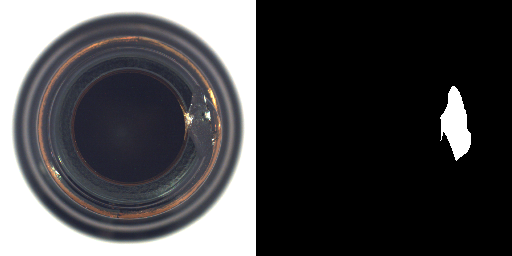

In [26]:
img = ToPILImage()(Denormalize()(sample["image"].clone()))
msk = ToPILImage()(sample["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

### DataModule

So far, we have shown the Torch Dateset implementation of MVTec AD dataset. This is quite useful to get a sample. However, when we train models end-to-end fashion, we do need much more than this such as downloading the dataset, creating train/val/test/inference dataloaders. To handle all these, we have the PyTorch Lightning DataModule implementation, which is shown below

In [28]:
mvtec_datamodule = MVTec(
    root="../../datasets/MVTec",
    category="bottle",
    image_size=256,
    train_batch_size=32,
    test_batch_size=32,
    num_workers=8,
    task="segmentation",
)
mvtec_datamodule.setup()

In [30]:
# Train images
i, data = next(enumerate(mvtec_datamodule.train_dataloader()))
data.keys(), data["image"].shape

(dict_keys(['image']), torch.Size([32, 3, 256, 256]))

In [32]:
# Test images
i, data = next(enumerate(mvtec_datamodule.test_dataloader()))
data.keys(), data["image"].shape, data["mask"].shape

(dict_keys(['image', 'image_path', 'label', 'mask_path', 'mask']),
 torch.Size([32, 3, 256, 256]),
 torch.Size([32, 256, 256]))

As can be seen above, creating the dataloaders are pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.

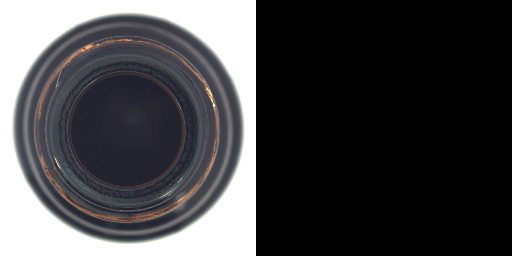

In [41]:
img = ToPILImage()(Denormalize()(data["image"][0].clone()))
msk = ToPILImage()(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))